# Week 12: 2018/04/23-27

In [1]:
from tock import *
from cooklevin import *
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline  

## Monday reading

Read Section 7.4, "The Cook-Levin Theorem."

## Tuesday class

To show that a language $L$ is NP-complete, we have two strategies. One is to directly show that any polynomial-time NTM can be reduced to $L$. The other is to show that a known NP-complete language can be reduced to $L$. But, we can't use the second strategy until we've taken the first strategy at least once. That is our job for today.

### The Cook-Levin Theorem

The Cook-Levin Theorem is that Boolean satisfiability (SAT) is NP-complete. SAT is the problem of deciding whether some Boolean formula (made of Boolean variables combined with and's, or's, and not's) has a truth-assignment that makes it true.

#### The big picture

The "proof idea" in the book is very clear; the main thing that is tricky is matching it up with the definition of NP-completeness.

We need to show, intuitively, that if SAT was decidable in polynomial time, then we would thereby have a way to decide _any_ language $A$ in NP in polynomial time.

More precisely, for any language $A$ in NP, we need to produce a polynomial-time reduction $f$ from strings to formulas such that $w \in A$ iff $\phi = f(w)$ is satisfiable. If we could do that, then we could use $f$ plus the SAT-solver to build an $A$-solver.

Equivalently, for any NTM $N$ that runs in polynomial time, we need to produce a polynomial-time reduction $f$ from strings to formulas such that $N$ accepts $w$ iff $\phi = f(w)$ is satisfiable. 

Thus, $\phi = f(w)$ encodes the run of machine $N$ on a particular string $w$. Our main job is to show how to implement $f$, that is, how to build this encoding $\phi$, and we have to do it in polynomial time.

#### The medium picture

The proof constructs a giant formula $\phi$. The variables of this formula are the contents of a $n^k \times n^k$ _tableau_ (see Figure 7.38) which encodes a step-by-step trace of the run of $N$ on $w$: the first row is the initial configuration, and the following rows are the steps of the run.

There are lots of possible assignments of true/false values to the variables, each of which corresponds to a way of filling in the tableau. (Note that many of these assignments are nonsense, e.g., writing more than one symbol in a cell. It's $\phi$'s job to check for this.)

The formula $\phi$ has four parts: $\phi = \phi_{\mathrm{cell}} \land \phi_{\mathrm{start}} \land \phi_{\mathrm{move}} \land \phi_{\mathrm{accept}}$. The purpose of these four parts is:

- $\phi_{\mathrm{cell}}$: Each cell contains exactly one symbol.
- $\phi_{\mathrm{start}}$: The first row of the tableau is the initial configuration of $N$.
- $\phi_{\mathrm{move}}$: Each row (except the first) is a configuration that legally follows the row above it according to $N$'s rules.
- $\phi_{\mathrm{accept}}$: The accept state occurs somewhere in the tableau.

You should see the book for the details of each of these four parts.

#### More details

The proof omits the details the construction of $\phi_{\mathrm{move}}$. The definition of $\phi_{\mathrm{move}}$ is given in the proof of Claim 7.41, and includes an iteration over all possible legal windows $a_1, \ldots, a_6$. The book just gives a few examples of legal windows (Figure 7.39) but doesn't list them all out. If you like details to be completely worked out, here they are.

The following are legal windows:

```
#bc  abc  ab#
#bc  abc  ab#
```

where a, b, and c are any tape symbols.

Recall that if there is a transition $\delta(q, b) = (r, c, \textrm{L})$, then the configuration $uaqbv$ yields configuration $uracv$, where $u$ and $v$ are strings of tape symbols. So the following are all legal windows:

```
xya  yaq  aqb  qbx  bxy
xyr  yra  rac  rax  axy
```

where $x$ and $y$ are any tape symbols.

We also need to consider what happens at the ends of the tape.

```
#ya  #aq  #qb  qb#  bx#
#yr  #ra  #rc  ra#  ax#
```
Note that in the center (third) window, the head does not move, because it's at the left end of the tape.

Similarly, if there is a transition $\delta(q,b)=(r,c,\textrm{R})$, then the configuration $uaqbv$ yields configuration $uacrv$. So the following are all legal windows:

```
yaq  aqb  qbx  bxy
yac  acr  crx  rxy

#aq  #qb       bx#
#ac  #cr       rx#
```

These 20 cases cover all possibilities -- nothing else is a legal window.

#### Demo

Here's a Turing machine we've seen before -- it accepts the language $\{\mathtt{x}^{2^k} \mid k \geq 0\}$. (Apologies that it's not nondeterministic.)

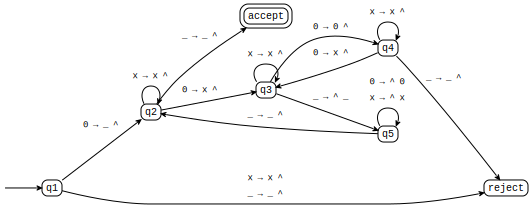

In [2]:
m = read_csv("tm-m2.csv")
m

Now we construct the formula corresponding to the run of this machine on `xx`:

In [5]:
phi = make_phi(m, ["x"]*2, 1)
print(phi)

(x[1,1,q1] | x[1,1,x] | x[1,1,q5] | x[1,1,q2] | x[1,1,0] | x[1,1,accept] | x[1,1,q3] | x[1,1,q4] | x[1,1,reject] | x[1,1,#] | x[1,1,_]) & (~x[1,1,q1] | ~x[1,1,x]) & (~x[1,1,q1] | ~x[1,1,q5]) & (~x[1,1,q1] | ~x[1,1,q2]) & (~x[1,1,q1] | ~x[1,1,0]) & (~x[1,1,q1] | ~x[1,1,accept]) & (~x[1,1,q1] | ~x[1,1,q3]) & (~x[1,1,q1] | ~x[1,1,q4]) & (~x[1,1,q1] | ~x[1,1,reject]) & (~x[1,1,q1] | ~x[1,1,#]) & (~x[1,1,q1] | ~x[1,1,_]) & (~x[1,1,x] | ~x[1,1,q1]) & (~x[1,1,x] | ~x[1,1,q5]) & (~x[1,1,x] | ~x[1,1,q2]) & (~x[1,1,x] | ~x[1,1,0]) & (~x[1,1,x] | ~x[1,1,accept]) & (~x[1,1,x] | ~x[1,1,q3]) & (~x[1,1,x] | ~x[1,1,q4]) & (~x[1,1,x] | ~x[1,1,reject]) & (~x[1,1,x] | ~x[1,1,#]) & (~x[1,1,x] | ~x[1,1,_]) & (~x[1,1,q5] | ~x[1,1,q1]) & (~x[1,1,q5] | ~x[1,1,x]) & (~x[1,1,q5] | ~x[1,1,q2]) & (~x[1,1,q5] | ~x[1,1,0]) & (~x[1,1,q5] | ~x[1,1,accept]) & (~x[1,1,q5] | ~x[1,1,q3]) & (~x[1,1,q5] | ~x[1,1,q4]) & (~x[1,1,q5] | ~x[1,1,reject]) & (~x[1,1,q5] | ~x[1,1,#]) & (~x[1,1,q5] | ~x[1,1,_]) & (~x[1,1,q2] | ~x[1,

That is a really big formula. How does the formula length depend on the input length?

In [18]:
lens = []
for n in range(10):
    phi = make_phi(m, ["x"]*n, 1)
    print(n, len(str(phi)))
    lens.append(len(str(phi)))

0 127263
1 345280
2 667329
3 1093410
4 1623523
5 2257668
6 2995845
7 3872935
8 4896025
9 6054315


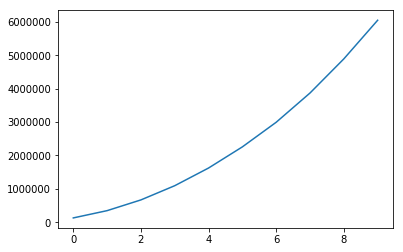

In [19]:
plt.plot(range(10), lens)
plt.show()

Does that look polynomial? If we switch to log-log scale, it should look like a straight line:

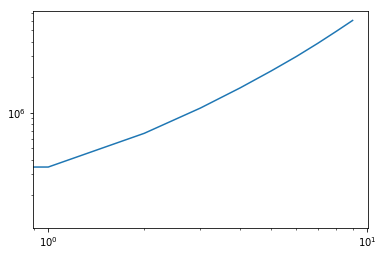

In [20]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(range(10), lens)
plt.show()

## Wednesday reading

Read Section 7.5.

## Thursday class

Last time we showed that SAT was NP-complete. That is, any language in NP has a polynomial-time mapping reduction to SAT. That is, for any NTM $N$, there is a way to convert any string $w$ in polynomial time to a Boolean formula $\phi$ such that $N$ accepts $w$ iff $\phi$ is satisfiable.

Then, we briefly showed that 3SAT was NP-complete, by reduction from SAT. That is, any  formula $\phi$ can be converted into a formula $\phi'$ in 3CNF such that $\phi$ is satisfiable iff $\phi'$ is satisfiable.

Section 7.5 shows that four more problems (clique, vertex cover, Hamiltonian path, subset sum) are NP-complete by reduction from 3SAT. We'll work through the first proof in class. Each of these proofs has the following parts (assuming reduction from 3SAT to a problem $L$):

- Show that the language is in NP. This step is usually very brief and just argues that verifying a _certificate_ (e.g., a clique) takes polynomial time.

- Describe the reduction $f$ from a formula in 3CNF to an instance of the problem you're trying to prove NP-complete. (Not the other direction!)

- Show that computing $f$ takes polynomial time.

- Show that if $\phi$ has a satisfying assignment, then $f(\phi)$ belongs to $L$.

- Conversely, show that if $f(\phi)$ belongs to $L$, then $\phi$ has a satisfying assignment.

**Question.** Show that solvability of the puzzle in Exercise 7.28 is NP-complete.

# Wrap-up

We started this class by asking "What is a computer?" You knew already that everything a computer does is written in programming languages that compile down to assembly code, and in assembly you have access to registers, memory, a stack, etc. We saw in this class that you could, in principle, further compile assembly code down to the instructions of a Turing machine, which accesses its memory (an infinite tape) by moving one location at a time and reading/write one location at a time. We took Turing machines to be our definition of computer: if you're designing a computer or a computer language, it must be able to implement any Turing machine.

Boiling the model down further reduces its power dramatically. If you change out the tape for a read-only input and maybe a stack, you get machines (finite automata and pushdown automata) that can do much less than Turing machines can. What you get in exchange is the ability to reason about these machines more easily. For example, a finite automaton is guaranteed to run in linear time and constant space. You can test whether two finite automata are equivalent to each other. Even though a pushdown automaton can go into an infinite loop, you can always detect and remove them.

Those are things that you can't do with Turing machines. You also can't write a Turing machine that says whether another program will crash, or do something malicious. And therefore, there is no known computer program that can do any of these things, either.

Finally, having a formal definition of a computer allows us to make important generalizations about efficiency. There is a large class of combinatorial problems (NP-complete problems) that we think have no tractable solution, but they are all interrelated such that if one of them has a tractable solution, then they all do.

There are many more topics in formal language theory, computability theory, and complexity theory that we might have covered, but didn't have time for. Though many theory topics are rather abstract, there are many ideas, in this class and beyond, that can help you to design better systems -- or to know when a better one doesn't exist. I hope that you found at least something in this course interesting, and that at least something you learned will be useful to you down the road!